# Problem 2

In [684]:
import pandas as pd
import numpy as np
from numpy import dot
from math import gamma,factorial,log,exp
import matplotlib.pyplot as plt

from numpy.linalg import inv

In [667]:
X_df=pd.read_csv('X.csv',header=-1)
y_df=pd.read_csv('y.csv',header=-1)
X_nm=["X"+str(x)for x in X_df.columns]
X_df.columns=X_nm
y_df.columns=['y']
df=pd.concat([X_df,y_df],axis=1)

In [594]:
def split(df,kf,std=None):
#     df is global
    
    perm=np.random.permutation(df.index.values)
    len_p=len(perm)
    idx_ls=[]
    left=0
    right=0
    for i in range(1,kf+1):
        left=int((i-1)/kf*len_p)
        right=int(i/kf*len_p)     
        idx_ls.append(perm[left:right])
    train_test=[]
    for i in range(kf):
        df2=df.copy()

        train_ls=[]
        for j in range(kf):
            if j!=i:
                train_ls.extend(idx_ls[j])
        train=df2.loc[train_ls,:].copy()
        test=df2.loc[idx_ls[i],:].copy()
        if std==1:
            for x in df.columns:
                if x!='y':
                    df2[x]=(df2[x]-train[x].mean())/train[x].std()
        X_test=df2.loc[idx_ls[i],X_nm].copy()
        y_test=df2.loc[idx_ls[i],'y'].copy()
        train=df2.loc[train_ls,:].copy()
        test=df2.loc[idx_ls[i],:].copy()
        print()
        X_train=df2.loc[train_ls,X_nm].copy()
        y_train=df2.loc[train_ls,'y'].copy()

        train_test.append([X_train,y_train,X_test,y_test,
                           train.reset_index().drop('index',axis=1),test.reset_index().drop('index',axis=1)])
    return train_test

In [292]:
def get_lambda(train):
    y1_train=train.loc[(train['y']==1),X_nm]
    y0_train=train.loc[(train['y']==0),X_nm]
    l_ls=[]
    len1=len(y1_train)
    len0=len(y0_train)
    l0=[(s+1)/(1+len0) for s in y0_train.sum().values]
    l1=[(s+1)/(1+len1) for s in y1_train.sum().values]
    return l0,l1

In [525]:
def get_pred(train,test):
    global lambdalist
    l0,l1=get_lambda(train)
    lambdalist.append([l0,l1])
    pred_ls=[]
    n,D=test.shape
    for i in range(n):
        x_ls=test.iloc[i].values
        prob1=log(pi)+sum([log(lambda_d)-lambda_d-log(gamma(2))+
                   (-log(lambda_d)+x_ls[d]*log(lambda_d)-log(factorial(x_ls[d]))) for lambda_d,d in zip(l1,range(D))])
        prob0=log(1-pi)+sum([log(lambda_d)-lambda_d-log(gamma(2))+
                   (-log(lambda_d)+x_ls[d]*log(lambda_d)-log(factorial(x_ls[d]))) for lambda_d,d in zip(l0,range(D))])
        if prob1>prob0:
            pred_ls.append(1) 
        else:
            pred_ls.append(0) 
    return pred_ls

In [335]:
def report(pred_ls,true_ls):
    mtx=np.array([[0,0],[0,0]])
    for y,yp in zip(true_ls,pred_ls):
        mtx[y][yp]+=1
    return mtx/len(pred_ls) ,(mtx/len(pred_ls))[0][0]+(mtx/len(pred_ls))[1][1]

In [526]:
def naive(df,kf):
    global lambdalist
    mtx_ls=[]
    accuracy_ls=[]
    for X_train,y_train,X_test,y_test,train_full,test_full in split(df,kf):
        mtx,ac=report(get_pred(train_full,test_full),test_full['y'].values)
        mtx_ls.append(mtx)
        accuracy_ls.append(ac)
    mean_mtx=[[np.mean([x[0][0] for x in mtx_ls]),np.mean([x[0][1] for x in mtx_ls])],
              [np.mean([x[1][0] for x in mtx_ls]),np.mean([x[1][1] for x in mtx_ls])]]
    mean_ac=np.mean(accuracy_ls)
    return mean_mtx,mean_ac

## (a)

#### Below is the matrix and the prediction accuracy

In [528]:
lambdalist=[]
t,a=naive(df,10)

In [529]:
print('the matrix is ',t[0],'\n\t\t',t[1])
print('the accuracy is ',a)

the matrix is  [0.4984782608695653, 0.1073913043478261] 
		 [0.02173913043478261, 0.37239130434782614]
the accuracy is  0.8708695652173913


## (b)

In [533]:
lambda0list=[x[0] for x in lambdalist]
lambda1list=[x[1] for x in lambdalist]

class0=np.average(lambda0list, axis=0)
class1=np.average(lambda1list, axis=0)


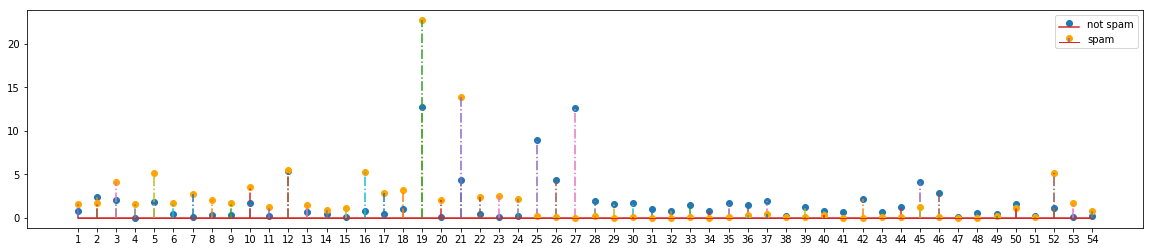

In [585]:
# returns 10 evenly spaced samples from 0.1 to 2*PI
x = df.columns[:-1]
plt.figure(figsize=(20,4))

markerline, stemlines, baseline = plt.stem(np.arange(1,55), class0, '-.',label='not spam')
markerline, stemlines, baseline = plt.stem(np.arange(1,55), class1, '-.',label='spam')

plt.setp(markerline,color='orange')
plt.setp(baseline, linewidth=1)
plt.xticks(np.arange(1,55))
plt.legend()
plt.show()


#### As we can see in this graph, dimension 16 and 52 has a significant difference in a spam email and a nonspam email. According to the readme, dimension 16 is the word "free" and dimension 52 is the punctuation "!". We can see the occurrence frequency for "free" and "!" is significantly larger in spam emails than in non spam emails.

## (c)

In [609]:
def KNN_pred(train,test,k):
    pred_ls=[]
    for i in range(len(test)):
        neighbors=pd.DataFrame(abs(train-test.values[i]).sum(axis=1)).sort_values(0).head(k).index.tolist()
        if train.loc[neighbors,'y'].mean()>0.5:
            pred_ls.append(1)
        else:
            pred_ls.append(0)
    return pred_ls

In [610]:
def KNN(df,k):
    mtx_ls=[]
    accuracy_ls=[]
    for X_train,y_train,X_test,y_test,train_full,test_full in split(df,kf,std=1):
        mtx,ac=report(KNN_pred(train_full,test_full,k),test_full['y'].values)
        mtx_ls.append(mtx)
        accuracy_ls.append(ac)
#         print(mtx,ac)
    mean_mtx=[[np.mean([x[0][0] for x in mtx_ls]),np.mean([x[0][1] for x in mtx_ls])],
              [np.mean([x[1][0] for x in mtx_ls]),np.mean([x[1][1] for x in mtx_ls])]]
    mean_ac=np.mean(accuracy_ls)
    return mean_mtx,mean_ac

In [612]:
ac_ls=[]
for k in range(1,21):
    _,ac=KNN(df,k)
    ac_ls.append(ac)


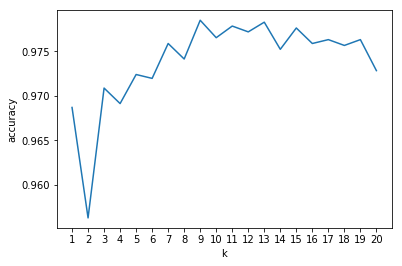

In [602]:
plt.plot(np.arange(1,21),ac_ls)
plt.xticks(np.arange(1,21))
plt.xlabel('k')
plt.show()

#### For KNN, I think it is necessary to standarize the input features, because the model is mostly dependent on the scale of our features, so I scaled it and all the prediction is done after standarization.

## (d)

In [603]:
df_l=df.copy()
df_l['Xc']=1
newy=df_l['y'].replace(0,-1).values
df_l.drop('y',axis=1,inplace=True)
df_l['y']=newy

In [481]:
X_train,y_train,X_test,y_test,train_full,test_full = split(df_l,kf)[0]

In [482]:
test=test_full.copy()
train=train_full.copy()

In [749]:
def sig(x):
    try:
        ans=exp(x)/(1+exp(x))
    except OverflowError:
        ans=1
    return ans
def sig2(x):
    try:
        ans=1/(2+exp(x)+1/exp(x))
    except OverflowError:
        ans=0
    return ans

def loss(mtx,w):
    mysum=0
    for r in range(len(train)):
        yi=mtx[r][-1]
        xi=mtx[r][:-1]
        mysum+=log(sig(yi*dot(w,xi)))
    return mysum    

def delta(mtx,w):
    mysum=np.zeros(len(w)) 
    for r in range(len(mtx)):
        yi=mtx[r][-1]
        xi=mtx[r][:-1]
#         raise Exception()
        mysum+=(1-sig(yi*dot(w,xi)))*yi*xi
    return mysum          


# def delta2(mtx,w):
#     mysum=np.zeros(len(w)) 
#     for r in range(len(mtx)):
#         yi=mtx[r][-1]
#         xi=mtx[r][:-1]
#         mysum+=-sig2(yi*dot(w,xi))*(xi*xi)
#     return mysum          


def delta2(mtx,w):
    mysum=np.zeros((len(w),len(w))) 
    for r in range(len(mtx)):
        yi=mtx[r][-1]
        xi=mtx[r][:-1]
        mysum+=-sig2(yi*dot(w,xi))*dot(np.transpose([xi]),[xi])
    return mysum  

def get_w(train,eta):
    w=np.zeros(train.shape[1]-1) 
    loss_ls=[]
    for i in range(1000):
        w=w+eta*delta(train.values,w)
        loss_ls.append(loss(train.values,w))
    return w,loss_ls

def get_w2(train,eta):
    w=np.zeros(train.shape[1]-1) 
    loss_ls=[]
    for i in range(100):
        w=w-dot(inv(delta2(train.values,w)),delta(train.values,w))
        loss_ls.append(loss(train.values,w))
    return w,loss_ls

def logit_class(x):
    if x>0.5:
        return 1
    else:
        return -1

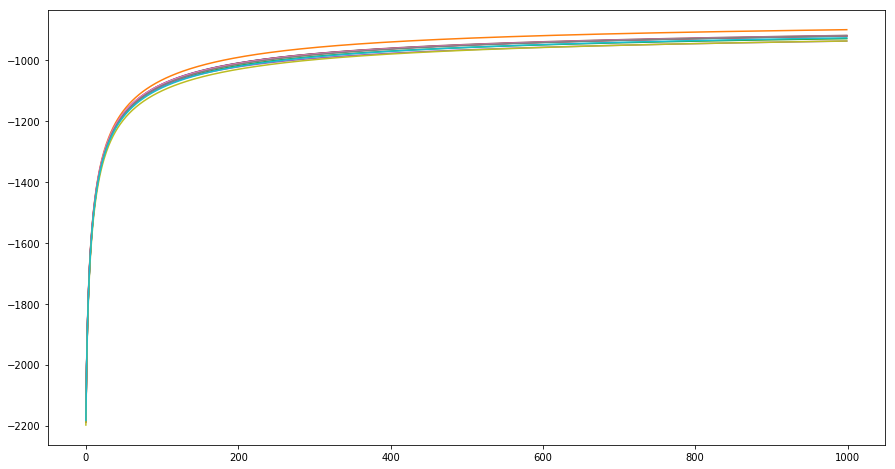

In [751]:
# def logit_plot():
plt.figure(figsize=(15,8))

for X_train,y_train,X_test,y_test,train_full,test_full in split(df_l,kf):
    test=test_full.copy()
    train=train_full.copy()
    eta=0.01/4600
    _,loss_ls=get_w(train,eta)
    plt.plot(np.arange(1000),loss_ls)
plt.show()

        

## (e)

We take the first derivative of $L'$ and let it equal to 0:  Let $\frac{\partial L^\prime\left(w\right)}{\partial w}=\mathrm{\nabla L}\left(w_t\right)+\mathrm{\nabla}^2L\left(w_t\right)\left(w-w_t\right)=0$Then we solve for $w_{t+1}$ and get the following update$w_{t+1}=\arg_w\max L'=w_{t}-\Delta^2{L}^{-1}\Delta{L}$ where $\Delta{L}=\sum_{i=1}^{n}\frac{y_i x_i}{1+e^{y_i x_i w_t}}$ and $\Delta^2{L}=-\sum_{i=1}^{n}\frac{e^{y_i x_i w_t}}{(1+e^{y_i x_i w_t})^2}x_ix_i^T$ which is the hessia matrix. $x_i$is the ith row vector

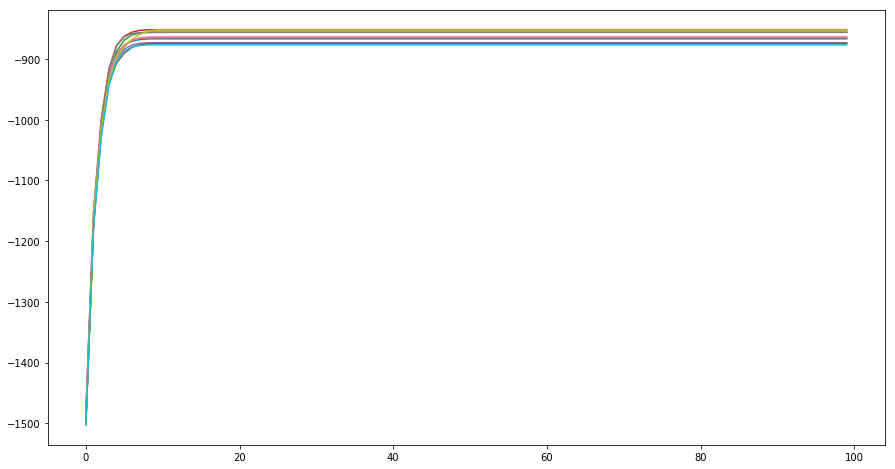

In [750]:
X_nm= df_l.columns[:-1]
plt.figure(figsize=(15,8))
mtx_ls=[]
ac_ls=[]

for X_train,y_train,X_test,y_test,train_full,test_full in split(df_l,kf):
    
    test=test_full.copy()
    train=train_full.copy()
    eta=0.01
    w2,loss_ls=get_w2(train,eta)
    ac_mtx=np.array([[0,0],[0,0]])
    for x,truey in zip(X_test.values,y_test.values):
        pred=logit_class(sig(dot(x,w2)))
        if truey==-1:
            truey=0
        if pred==-1:
            pred=0
        ac_mtx[truey][pred]+=1
    ac=ac_mtx[0][0]+ac_mtx[1][1]
    mtx_ls.append(ac_mtx/X_test.shape[0])
    ac_ls.append(ac/X_test.shape[0])
    plt.plot(np.arange(100),loss_ls)
    
plt.show()

## (f)

In [752]:
print('the matrix is ',np.average(mtx_ls,axis=0))
print('the accuracy is ',np.mean(ac_ls))

the matrix is  [[0.57456522 0.03130435]
 [0.04630435 0.34782609]]
the accuracy is  0.922391304347826
